In [ ]:
#default_exp audio.core
#default_cls_lvl 3

In [ ]:
%matplotlib inline

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc
import torchaudio
import torchaudio.transforms as torchaud_tfm

from IPython.display import display, Audio
from dataclasses import dataclass, asdict, is_dataclass, make_dataclass
from torchaudio.transforms import Spectrogram, AmplitudeToDB, MFCC
from librosa.display import specshow, waveplot

In [ ]:
torchaudio.__version__

'0.3.0+faed00e'

In [ ]:
#TensorBase??

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Create __all__ for audio</div>

In [ ]:
#export
_all_ = ['AudioGetter', 'get_audio_files', 'AudioItem', 'OpenAudio', 'AudioSpectrogram', 'AudioToSpec',
        'SpectrogramConfig', 'AudioConfig', 'audio_extensions']

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#export
audio_extensions = tuple(str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): 
        return get_audio_files(o/suf, recurse, folders)
    return _inner

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Get data_url stuff working</div>

In [ ]:
# data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
# data_folder = download_url(data_url, get_path(data_url))

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')

In [ ]:
p.ls()

(#3844) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
audio_get_func = AudioGetter("", recurse=True, folders=None)

In [ ]:
audio_get_func

<function __main__.AudioGetter.<locals>._inner(o, recurse=True, folders=None)>

In [ ]:
files = audio_get_func(p)

In [ ]:
files[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br> 
    1. Return to lazy loading. <br>
    2. Refactor out @property pattern using the fastai v2 way <br>
    3. Get rid of path as part of the tuple? <br>
</div>

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Factor</div

In [ ]:
#export
class AudioItem(tuple):
    def show(self, ctx=None, **kwargs): 
        print(f"File: {self.path}")
        display(Audio(self.sig, rate=self.sr))
        display(waveplot(self.sig.squeeze(0).numpy(), self.sr, ax=ctx, **kwargs))
    
    @classmethod
    def create(cls, fn, **kwargs):
        sig, sr = torchaudio.load(fn)
        return cls((sig, sr, fn))
    
    @property
    def sig(self) : return self[0]
    @property
    def sr(self)  : return self[1]
    @property
    def path(self): return self[2]
    @property
    def duration(self): return self.nsamples/float(self.sr)
    @property
    def nsamples(self): return self.sig.shape[-1]
    @property
    def nchannels(self): return self.sig.shape[0]

In [ ]:
type(AudioItem((None, None, files[0])))

__main__.AudioItem

In [ ]:
test_item = AudioItem.create(files[0]); test_item

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
          -6.1035e-05, -1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'))

In [ ]:
test_item[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
         -6.1035e-05, -1.8311e-04]])

In [ ]:
test_item.sr, test_item.duration, test_item.nchannels, test_item.nsamples

(16000, 3.28, 1, 52480)

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


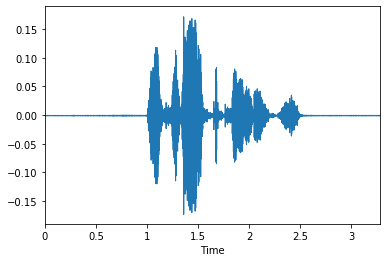

In [ ]:
test_item.show()

In [ ]:
#export
class OpenAudio(Transform):
    def __init__(self, items):
        self.items = items

    def encodes(self, i):
        o = self.items[i]
        return AudioItem.create(o)
    
    def decodes(self, i)->Path: 
        return self.items[i]

repr of Transform is:  
classname: self.use_as_item {self.encodes} {self.decodes}  
encodes and decodes are TypeDispatches whose reprs are str of dict where k/v pair is typename and function that handles that type

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True {'object': 'encodes'} {'object': 'decodes'}

In [ ]:
type(oa)

__main__.OpenAudio

In [ ]:
#??Transform
#??TypeDispatch

In [ ]:
oa.encodes(1)

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.0518e-05,
          -1.2207e-04,  1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav'))

In [ ]:
oa.decodes(1)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav')

In [ ]:
oa.items[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

## Create functions to wrap TorchAudio 

In [ ]:
#export
_GenSpec    = torchaudio.transforms.Spectrogram
_GenMelSpec = torchaudio.transforms.MelSpectrogram
_GenMFCC    = torchaudio.transforms.MFCC
_ToDB        = torchaudio.transforms.AmplitudeToDB

In [ ]:
#export
def get_usable_kwargs(func, args):
    return {k:v for k,v in args.items() if k in inspect.signature(func).parameters.keys()}

def add_func(func, kwargs):
        func_args = get_usable_kwargs(func, kwargs)
        return func(**func_args)

## Audio Spectrogram

In [ ]:
# TensorImageBase??
# TensorImage??
# TensorBase??
# Tensor??
# BypassNewMeta??

In [ ]:
#??TensorImageBase

#export
<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br>
    1. Add proper axis labels based on settings, get colorbar working <br>
    2. Clean up/Refactor <br>
    3. Add testing for plotting various channels/deltas</div><br>

In [ ]:
#export
class AudioSpectrogram(TensorImageBase):
    @classmethod
    def create(cls, sg, settings=None, path=None, start=None, end=None):
        x = cls(sg)
        store_attr(x, 'settings,path,start,end')
        return x
   
    def show(self, figsize=None, ax=None, ctx=None, **kwargs):
        #sg = torch.cat([self]*8, 0)
        ax = ifnone(ax,ctx)
        nchannels = self.settings["nchannels"]
        #nchannels=2
        r, c = nchannels, sg.shape[0]//nchannels
        proper_kwargs = get_usable_kwargs(specshow, self.settings["tfm_kwargs"])
        if (r == 1 and c == 1):
            _ = specshow(self.squeeze(0).numpy(), sr=self.settings["sr"], cmap="viridis", **proper_kwargs)
            
        else:
            if figsize is None: figsize = (4*c, 3*r)
            if ax is None: _,ax = plt.subplots(r, c, figsize=figsize)
            for i, channel in enumerate(sg):
                cur_ax = ax[i//c,i%c] if r > 1 else ax[i%c]
                cur_ax.set_title(f"Channel {i//c} Image {i%c}")
                _ = specshow(channel.numpy(), sr=self.settings["sr"], ax=cur_ax, cmap="viridis", **proper_kwargs)
               

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Add in the thing that catches bad kwargs</div

<div class='alert alert-block alert-info'><strong>Idea:</strong> Since we are grouping 3 functions signatures together here and it can get a bit confusing, we could add a check_kwargs in the init that warns if unused kwargs are being passed in. For instance if you pass in n_mels but mel=False, or top_db when to_db = False</div

In [ ]:
#export
@delegates(_GenSpec.__init__)
@delegates(_GenMelSpec.__init__, keep=True)
@delegates(_ToDB.__init__, keep=True)
class AudioToSpec(Transform):
    def __init__(self, mel=True, to_db=True, **kwargs):
        transforms = L()
        if mel:   transforms += add_func(_GenMelSpec, kwargs)
        else:     transforms += add_func(_GenSpec, kwargs)
        if to_db: transforms += add_func(_ToDB, kwargs)
            
        self.transformer = nn.Sequential(*transforms)
        store_attr(self, 'to_db,mel')
        self.tfm_kwargs = kwargs
        
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else audio_cfg
        return cls(**cfg)
    
    def encodes(self, x:AudioItem):
        self.sr, self.nchannels = x.sr, x.nchannels
        return AudioSpectrogram.create(self.transformer(x.sig).detach(), settings=self.__dict__)
    

In [ ]:
#export
@delegates(_GenMFCC.__init__)
class AudioToMFCC(Transform):
    def __init__(self,**kwargs):
        self.transformer = add_func(_GenMFCC, kwargs)
        self.tfm_kwargs = kwargs
        
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else audio_cfg
        return cls(**cfg)
    
    def encodes(self, x:AudioItem):
        self.sr, self.nchannels = x.sr, x.nchannels
        return AudioSpectrogram.create(self.transformer(x.sig).detach(), settings=self.__dict__)

In [ ]:
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
AudioToSpec(**voice_mel_cfg)
AudioToSpec()

AudioToSpec: True {'AudioItem': 'encodes'} {}

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav


<class '__main__.AudioSpectrogram'>


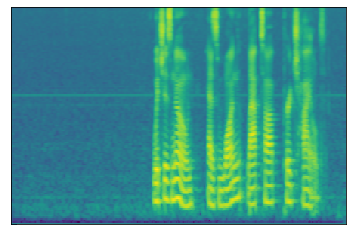

In [ ]:
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()
a2s = AudioToSpec(**voice_mel_cfg)
sg = a2s(item100)
print(type(sg))
sg.show()

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br>
    1. Remove SpectrogramConfig/settings and just dump all settings in the function?</div><br>

In [ ]:
AudioToMFCC()

AudioToMFCC: True {'AudioItem': 'encodes'} {}

<div class='alert alert-block alert-warning'><strong>Issue:</strong><br>
    Pipe is only displaying one thing instead of multiple</div><br>

### MelSpecPipe

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav


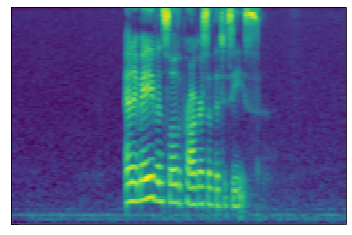

In [ ]:
mel_cfg = {'n_fft':2560,'hop_length':256}
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()
a2s = AudioToSpec(**mel_cfg)
#a2s(item100).show()
db_mel_pipe = Pipeline([oa,AudioToSpec(**mel_cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### Raw Spec Pipe

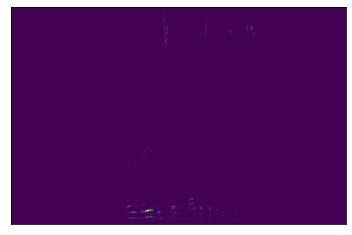

In [ ]:
cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec(mel=False, to_db=False,)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### DBScale non-mel Pipe

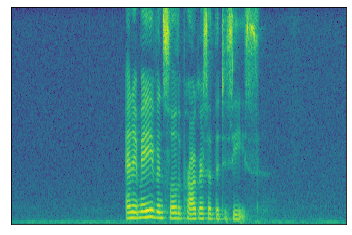

In [ ]:
cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec(mel=False)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### from config pipe 

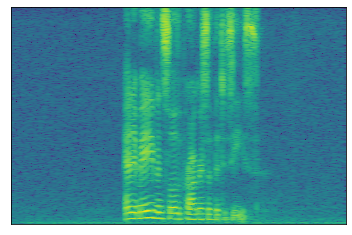

In [ ]:
cfg = {'mel':False, 'n_fft':2560, 'f_max':22050., 'hop_length':64}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### MFCC Pipe

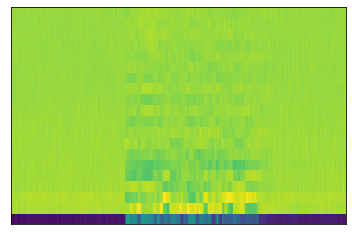

In [ ]:
db_mfcc_pipe = Pipeline([oa, AudioToMFCC(n_mfcc=20), ], as_item=True)
for i in range(3): 
    db_mfcc_pipe.show(db_mfcc_pipe(i))

## Configs

In [ ]:
f = inspect.signature(torchaud_tfm.Spectrogram).parameters

In [ ]:
f["n_fft"].default

400

In [ ]:
#export
def config_from_func(func, name, **kwargs):
    args = inspect.signature(func).parameters
    namespace = {k:v.default for k, v in args.items()}
    namespace.update(**kwargs)
    return make_dataclass(name, args, namespace=namespace)

#default configurations from the wrapped function
SpectrogramConfig    = config_from_func(_GenSpec, "SpectrogramConfig")
MelSpectrogramConfig = config_from_func(_GenMelSpec, "MelSpectrogramConfig")
MFCCConfig           = config_from_func(_GenMFCC, "MFCCConfig")
#special configs with domain-specific defaults
VoiceMelConfig = config_from_func(_GenMelSpec, "VoiceMelConfig", f_min=50, f_max=8000, n_mels=64)

In [ ]:
sg_cfg = SpectrogramConfig(n_fft=2000); sg_cfg

SpectrogramConfig(n_fft=2000, win_length=None, hop_length=None, pad=0, window_fn=<built-in method hann_window of type object at 0x7f499d8440a0>, power=2, normalized=False, wkwargs=None)

In [ ]:
MelSpectrogramConfig(hop_length=128)

MelSpectrogramConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=128, f_min=0.0, f_max=None, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7f499d8440a0>, wkwargs=None)

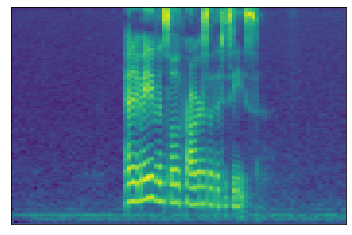

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
vm = VoiceMelConfig(); vm

VoiceMelConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=None, f_min=50, f_max=8000, pad=0, n_mels=64, window_fn=<built-in method hann_window of type object at 0x7f499d8440a0>, wkwargs=None)

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(vm)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

RuntimeError: 

create_fb_matrix(int n_freqs, float f_min, float f_max, int n_mels) -> (Tensor):
Expected a value of type 'float' for argument 'f_min' but instead found type 'int'.
:
at /opt/anaconda3/envs/dev/lib/python3.7/site-packages/torchaudio/transforms.py:147:22
    def forward(self, specgram):
        r"""
        Args:
            specgram (torch.Tensor): A spectrogram STFT of dimension (channel, freq, time)

        Returns:
            torch.Tensor: Mel frequency spectrogram of size (channel, ``n_mels``, time)
        """
        if self.fb.numel() == 0:
            tmp_fb = F.create_fb_matrix(specgram.size(1), self.f_min, self.f_max, self.n_mels)
                     ~~~~~~~~ <--- HERE
            # Attributes cannot be reassigned outside __init__ so workaround
            self.fb.resize_(tmp_fb.size())
            self.fb.copy_(tmp_fb)

        # (channel, frequency, time).transpose(...) dot (frequency, n_mels)
        # -> (channel, time, n_mels).transpose(...)
        mel_specgram = torch.matmul(specgram.transpose(1, 2), self.fb).transpose(1, 2)
        return mel_specgram
'__module__.___torch_mangle_214.MelScale.forward' is being compiled since it was called from '__module__.___torch_mangle_211.MelScale.forward'
at /opt/anaconda3/envs/dev/lib/python3.7/site-packages/torchaudio/transforms.py:67:59
        Args:
            waveform (torch.Tensor): Tensor of audio of dimension (channel, time)

        Returns:
            torch.Tensor: Dimension (channel, freq, time), where channel
            is unchanged, freq is ``n_fft // 2 + 1`` where ``n_fft`` is the number of
            Fourier bins, and time is the number of window hops (n_frames).
        """
        return F.spectrogram(waveform, self.pad, self.window, self.n_fft, self.hop_length,
                             self.win_length, self.power, self.normalized)
                                                          ~~~~~~~~~~~~~~~ <--- HERE


In [ ]:
MFCCConfig()

In [ ]:
VoiceMelConfig()

## Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)